In [1]:
# safe downcast
def sd(col, max_loss_limit=0.001, avg_loss_limit=0.001, na_loss_limit=0, n_uniq_loss_limit=0, fillna=0):
    """
    max_loss_limit - don't allow any float to lose precision more than this value. Any values are ok for GBT algorithms as long as you don't unique values.
                     See https://en.wikipedia.org/wiki/Half-precision_floating-point_format#Precision_limitations_on_decimal_values_in_[0,_1]
    avg_loss_limit - same but calculates avg throughout the series.
    na_loss_limit - not really useful.
    n_uniq_loss_limit - very important parameter. If you have a float field with very high cardinality you can set this value to something like n_records * 0.01 in order to allow some field relaxing.
    """
    is_float = str(col.dtypes)[:5] == 'float'
    na_count = col.isna().sum()
    n_uniq = col.nunique(dropna=False)
    try_types = ['float16', 'float32']

    if na_count <= na_loss_limit:
        try_types = ['int8', 'int16', 'float16', 'int32', 'float32']

    for type in try_types:
        col_tmp = col

        # float to int conversion => try to round to minimize casting error
        if is_float and (str(type)[:3] == 'int'):
            col_tmp = col_tmp.copy().fillna(fillna).round()

        col_tmp = col_tmp.astype(type)
        max_loss = (col_tmp - col).abs().max()
        avg_loss = (col_tmp - col).abs().mean()
        na_loss = np.abs(na_count - col_tmp.isna().sum())
        n_uniq_loss = np.abs(n_uniq - col_tmp.nunique(dropna=False))

        if max_loss <= max_loss_limit and avg_loss <= avg_loss_limit and na_loss <= na_loss_limit and n_uniq_loss <= n_uniq_loss_limit:
            return col_tmp

    # field can't be converted
    return col


def reduce_mem_usage(df, deep=True, verbose=False, obj_to_cat=False):
    numerics = ['int16', 'uint16', 'int32', 'uint32', 'int64', 'uint64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes

        # collect stats
        na_count = df[col].isna().sum()
        n_uniq = df[col].nunique(dropna=False)
        
        # numerics
        if col_type in numerics:
            df[col] = sd(df[col])

        # strings
        if (col_type == 'object') and obj_to_cat:
            df[col] = df[col].astype('category')
        
        if verbose:
            print(f'Column {col}: {col_type} -> {df[col].dtypes}, na_count={na_count}, n_uniq={n_uniq}')
        new_na_count = df[col].isna().sum()
        if (na_count != new_na_count):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost na values. Before: {na_count}, after: {new_na_count}')
        new_n_uniq = df[col].nunique(dropna=False)
        if (n_uniq != new_n_uniq):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost unique values. Before: {n_uniq}, after: {new_n_uniq}')

    end_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    if verbose:
        print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

## <span id="1"></span> ** 1. Importing Libraries and Reading the Dataset **

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv


In [3]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import gc, datetime, random
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

import pickle

def save_to_disk(obj, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

pd.options.display.max_rows = 4000

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 42
seed_everything(SEED)
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [4]:
%%time
train_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv', index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

y = train['isFraud'].copy()
del train_transaction, train_identity, test_transaction, test_identity

# Drop target, fill in NaNs
train = train.drop('isFraud', axis=1)

Train shape:  (590540, 433)
Test shape:  (506691, 432)
CPU times: user 56.2 s, sys: 30.1 s, total: 1min 26s
Wall time: 1min 18s


In [5]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

## <span id="2"></span> ** 2. Feature Engineering **

### <span id="3"></span> ** Add New Features **

In [6]:
def addNewFeatures(data): 
    data['uid'] = data['card1'].astype(str)+'_'+data['card2'].astype(str)

    data['uid2'] = data['uid'].astype(str)+'_'+data['card3'].astype(str)+'_'+data['card5'].astype(str)

    data['uid3'] = data['uid2'].astype(str)+'_'+data['addr1'].astype(str)+'_'+data['addr2'].astype(str)

    data['D9'] = np.where(data['D9'].isna(),0,1)
    
    return data

train = addNewFeatures(train)
test = addNewFeatures(test)

In [7]:
i_cols = ['card1','card2','card3','card5','uid','uid2','uid3']

for col in i_cols:
    for agg_type in ['mean','std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        #temp_df['TransactionAmt'] = temp_df['TransactionAmt'].astype(int)
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})

        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   

        train[new_col_name] = train[col].map(temp_df)
        test[new_col_name]  = test[col].map(temp_df)

train = train.replace(np.inf,999)
test = test.replace(np.inf,999)

In [8]:
train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt'])

### <span id="4"></span> ** Handle Email Domains **

In [9]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other',
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft',
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other',
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo',
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo',
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo',
          'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other',
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple',
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other',
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

### <span id="5"></span> ** Handle P Email Domain and R Email Domain **

In [10]:
p = 'P_emaildomain'
r = 'R_emaildomain'
uknown = 'email_not_provided'

def setDomain(df):
    df[p] = df[p].fillna(uknown)
    df[r] = df[r].fillna(uknown)
    
    # Check if P_emaildomain matches R_emaildomain
    df['email_check'] = np.where((df[p]==df[r])&(df[p]!=uknown),1,0)

    df[p+'_prefix'] = df[p].apply(lambda x: x.split('.')[0])
    df[r+'_prefix'] = df[r].apply(lambda x: x.split('.')[0])
    
    return df
    
train=setDomain(train)
test=setDomain(test)

### <span id="6"></span> ** Set Time **

In [11]:
def setTime(df):
    df['TransactionDT'] = df['TransactionDT'].fillna(df['TransactionDT'].median())
    # Temporary
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
#     df['DT_M'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
#     df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
#     df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
#     df['DT_day'] = df['DT'].dt.day
    
    return df
    
train=setTime(train)
test=setTime(test)

### Normalize D* features by trend

In [12]:
trends = {
    'D1': [(453.557, 613.017), (335.379, 487.827)],
    'D2': [(453.557, 613.017), (335.379, 487.827)],
    'D3': [(515.803, 630.), (335.163, 457.923)],
    'D4': [(515.298, 689.073), (335.163, 488.54)],
    'D5': [(514.,670.), (335.595, 465.903)],
    'D6': [(515.514, 602.702), (335.595, 389.906)],
    'D7': [(515.947, 559.162), (335.379, 377.205)],
    'D8': [(514.865, 1298.05), (335.163, 1113.72)],
    'D10': [(515.37, 675.59), (335.451, 492.4)],
    'D11': [(515.298, 674.197), (335.379,484.004)],
    'D12': [(515.947,651.695), (335.812,470.355)],
    'D13': [(499.512,810.655), (337.758,702.105)],
    'D14': [(515.298,871.374), (336.028,697.996)],
    'D15': [(515.298, 678.383), (335.163, 483.718)]
}

def normalize_by_trend(df, col, period):
    if col in trends:
        end_x, end_y = trends[col][0]
        start_x, start_y = trends[col][1]
        trend = period.apply(lambda x: start_y + (x - start_x)*(end_y-start_y)/(end_x-start_x))
        return df[col]/trend
    return df[col]

for df in [train, test]:
    dt = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    dt_d = ((dt.dt.year-2017)*365 + dt.dt.dayofyear).astype(np.int16)
    for col in trends:
        df[col] = normalize_by_trend(df, col, dt_d)

### <span id="7"></span> ** Handle Browser Version **

In [13]:
train["lastest_browser"] = np.zeros(train.shape[0])
test["lastest_browser"] = np.zeros(test.shape[0])

def setBrowser(df):
    df.loc[df["id_31"]=="samsung browser 7.0",'lastest_browser']=1
    df.loc[df["id_31"]=="opera 53.0",'lastest_browser']=1
    df.loc[df["id_31"]=="mobile safari 10.0",'lastest_browser']=1
    df.loc[df["id_31"]=="google search application 49.0",'lastest_browser']=1
    df.loc[df["id_31"]=="firefox 60.0",'lastest_browser']=1
    df.loc[df["id_31"]=="edge 17.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 69.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 67.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for ios",'lastest_browser']=1
    return df

train=setBrowser(train)
test=setBrowser(test)

### <span id="8"></span> ** Handle Device Type **

In [14]:
def setDevice(df):
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]

    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    df['had_id'] = 1
    gc.collect()
    
    return df

train=setDevice(train)
test=setDevice(test)

### <span id="9"></span> ** Set Frequency **

In [15]:
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
#           'D1','D2','D3','D4','D5','D6','D7','D8',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo','device_name',
          'id_30','id_33',
          'uid','uid2','uid3',
         ]

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc']  = test[col].map(fq_encode)


# for col in ['DT_M','DT_W','DT_D']:
#     temp_df = pd.concat([train[[col]], test[[col]]])
#     fq_encode = temp_df[col].value_counts().to_dict()
            
#     train[col+'_total'] = train[col].map(fq_encode)
#     test[col+'_total']  = test[col].map(fq_encode)
        

# periods = ['DT_M','DT_W','DT_D']
# i_cols = ['uid']
# for period in periods:
#     for col in i_cols:
#         new_column = col + '_' + period
            
#         temp_df = pd.concat([train[[col,period]], test[[col,period]]])
#         temp_df[new_column] = temp_df[col].astype(str) + '_' + (temp_df[period]).astype(str)
#         fq_encode = temp_df[new_column].value_counts().to_dict()
            
#         train[new_column] = (train[col].astype(str) + '_' + train[period].astype(str)).map(fq_encode)
#         test[new_column]  = (test[col].astype(str) + '_' + test[period].astype(str)).map(fq_encode)
        
#         train[new_column] /= train[period+'_total']
#         test[new_column]  /= test[period+'_total']

## <span id="10"></span> ** 3. Data Preprocessing **

In [16]:
def get_too_many_null_attr(data):
    many_null_cols = [col for col in data.columns if data[col].isnull().sum() / data.shape[0] > 0.9]
    return many_null_cols

def get_too_many_repeated_val(data):
    big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    return big_top_value_cols

def get_useless_columns(data):
    too_many_null = get_too_many_null_attr(data)
    print("More than 90% null: " + str(len(too_many_null)))
    too_many_repeated = get_too_many_repeated_val(data)
    print("More than 90% repeated value: " + str(len(too_many_repeated)))
    cols_to_drop = list(set(too_many_null + too_many_repeated))
    #cols_to_drop.remove('isFraud')
    return cols_to_drop

In [17]:
cols_to_drop = get_useless_columns(train)

More than 90% null: 12
More than 90% repeated value: 70


In [18]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [19]:
print(train.shape)
print(test.shape)
print(y.shape)

(590540, 423)
(506691, 423)
(590540,)


In [20]:
numerical_cols = train.select_dtypes(exclude = 'object').columns
categorical_cols = train.select_dtypes(include = 'object').columns

In [21]:
categorical_cols[:5]

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain'], dtype='object')

In [22]:
# Label Encoding
for f in train.columns:
    if train[f].dtype.name =='object' or test[f].dtype.name =='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

In [23]:
train = train.fillna(-999)
test = test.fillna(-999)

In [24]:
print(train.isnull().sum().max())
print(test.isnull().sum().max())

0
0


In [25]:
train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,dist1_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,DeviceInfo_fq_enc,device_name_fq_enc,id_30_fq_enc,id_33_fq_enc,uid_fq_enc,uid2_fq_enc,uid3_fq_enc
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,86400,4.241327,4,13926,-999.0,150.0,1,142.0,1,315.0,...,4707,163648,824070,863508,863508,949007,953271,6,6,2
2987001,86401,3.401197,4,2755,404.0,150.0,2,102.0,1,325.0,...,643488,435803,824070,863508,863508,949007,953271,1328,1328,105
2987002,86469,4.094345,4,4663,490.0,150.0,4,166.0,2,330.0,...,38,9934,824070,863508,863508,949007,953271,1787,1787,46
2987003,86499,3.931826,4,18132,567.0,150.0,2,117.0,2,476.0,...,643488,182784,824070,863508,863508,949007,953271,7602,7602,362
2987004,86506,3.931826,1,4497,514.0,150.0,2,102.0,1,420.0,...,643488,435803,824070,9,42979,3573,1430,30,30,1


In [26]:
TransactionDT1 = train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
dt_m = TransactionDT1.dt.date.astype('str').str[:7]

In [27]:
X = train.drop(['TransactionDT', 'DT'], axis=1)
X_test = test.drop(['TransactionDT', 'DT'], axis=1)

In [28]:
print("X:", X.shape)
print("y_train:", y.shape)
print("X_test:", X_test.shape)

X: (590540, 421)
y_train: (590540,)
X_test: (506691, 421)


## <span id="11"></span> ** 4. Model **

### <span id="12"></span> ** LightGBM **

In [29]:
params = {'num_leaves': 546,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.1797454081646243,
          'bagging_fraction': 0.2181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.005883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3299927210061127,
          'reg_lambda': 0.3885237330340494,
          'random_state': 99,
}

### Fit predict

In [30]:
%%time

columns = X.columns
y_preds = np.zeros(X_test.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

NFOLDS = len(np.unique(dt_m)) # 6

for fold_n, month in enumerate(np.unique(dt_m)):
    X_train, y_train = X[~dt_m.isin([month])][columns], y[~dt_m.isin([month])]
    X_valid, y_valid = X[dt_m.isin([month])][columns], y[dt_m.isin([month])]
    print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    save_to_disk(y_pred_valid, 'y_pred_valid_fold{}.pkl'.format(fold_n))
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    
    y_pred_test = clf.predict(X_test)
    save_to_disk(y_pred_test, 'y_pred_test_fold{}.pkl'.format(fold_n))
    y_preds += y_pred_test / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")

(453219, 421) (453219,) (137321, 421) (137321,)
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.956875	valid_1's auc: 0.888098
[400]	training's auc: 0.974569	valid_1's auc: 0.899611
[600]	training's auc: 0.98564	valid_1's auc: 0.906925
[800]	training's auc: 0.991892	valid_1's auc: 0.911329
[1000]	training's auc: 0.995351	valid_1's auc: 0.913601
[1200]	training's auc: 0.997332	valid_1's auc: 0.915279
[1400]	training's auc: 0.998428	valid_1's auc: 0.916268
[1600]	training's auc: 0.999073	valid_1's auc: 0.916615
[1800]	training's auc: 0.99946	valid_1's auc: 0.917028
[2000]	training's auc: 0.999683	valid_1's auc: 0.91691
[2200]	training's auc: 0.999814	valid_1's auc: 0.917048
[2400]	training's auc: 0.999893	valid_1's auc: 0.917138
[2600]	training's auc: 0.999939	valid_1's auc: 0.917271
[2800]	training's auc: 0.999966	valid_1's auc: 0.917391
[3000]	training's auc: 0.999981	valid_1's auc: 0.917581
[3200]	training's auc: 0.99999	valid_1's auc: 0.917795
[

## <span id="13"></span> ** 5. Submission **

In [31]:
submission = pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv')

In [32]:
submission['isFraud'] = y_preds

In [33]:
submission.head()

,TransactionID,isFraud
0,3663549,0.000418
1,3663550,0.001313
2,3663551,0.001088
3,3663552,0.000953
4,3663553,0.000804


In [34]:
submission.to_csv('submission.csv', index=False)

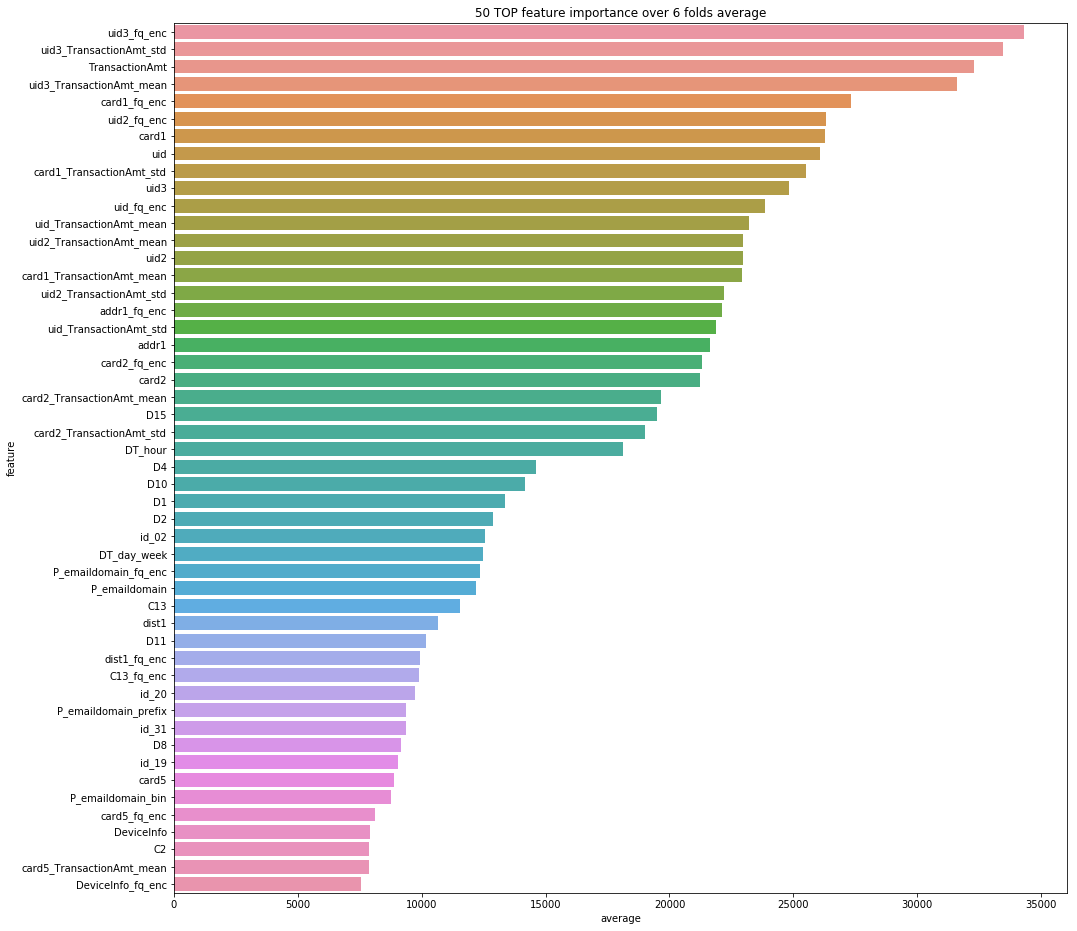

In [35]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(NFOLDS)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(NFOLDS));